In [86]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")
from os import path
import tempfile

import numpy as np
import scipy
from scipy.spatial.transform.rotation import Rotation as R
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio
import seaborn as sns

from experiment.v1dd_em_client import V1DDEMClient
import analysis_tools as at

at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_57162/2791394785.py:9: DeprecationWarning: Please use `Rotation` from the `scipy.spatial.transform` namespace, the `scipy.spatial.transform.rotation` namespace is deprecated.
  from scipy.spatial.transform.rotation import Rotation as R


In [31]:
em_client = V1DDEMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
cell_type_table = em_client.get_cell_type_table()
cell_type_table.head()

,index,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proofreading_status,dendrite_proofreading_status
0,0,1132,t,350562,coarse_manual,PYC,350562,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]","[-13.227572489957907, 226.5862979342913, -382....",not_started,not_started
1,1,214,t,383955,coarse_manual,PYC,383955,t,504.192300,95649060060623076,864691132569667100,"[920802, 795478, 329220]","[914826, 790822, 34920]","[926389, 800366, 36123]","[14.741818935006158, 576.1578669978572, -307.2...",not_started,not_started
2,2,13,t,385028,coarse_manual,PYC,385028,t,415.785065,95863052645657911,864691132781402571,"[929338, 898530, 386595]","[924914, 892245, 41162]","[933994, 903885, 42103]","[23.848399659480666, 690.7637364002102, -279.5...",not_started,not_started
3,3,717,t,293764,coarse_manual,PYC,293764,t,231.369357,94450111081742956,864691132625300120,"[878665, 697702, 245475]","[874009, 694365, 26030]","[883554, 701349, 26859]","[-27.97517873296875, 459.74380331495826, -361....",not_started,not_started
4,4,2604,t,351373,coarse_manual,PYC,351373,t,277.321739,96276193669654108,864691132689074198,"[944314, 572378, 210330]","[939814, 568187, 22179]","[948505, 576413, 23110]","[37.02512562261708, 329.260361441734, -362.108...",not_started,not_started


In [6]:
mc_cells = cell_type_table[cell_type_table.cell_type == "MC"]
print(f"There are {len(mc_cells)} typed MC cells in total")
mc_cells.head()

There are 75 typed MC cells in total


,index,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proofreading_status,dendrite_proofreading_status
27,27,2694,t,278405,coarse_manual,MC,278405,t,336.579200,90436412738338039,864691132823412073,"[737898, 601710, 294075]","[732777, 597520, 31127]","[742554, 605668, 32199]","[-169.1360545116018, 380.96626861854804, -289....",not_started,allen_qa
68,68,3103,t,382939,coarse_manual,MC,382939,t,365.528991,96564884326155374,864691132680249683,"[954713, 832803, 276660]","[950367, 827604, 29372]","[959446, 838080, 30230]","[48.76137539402035, 597.8819747458596, -367.91...",not_started,not_started
162,162,2476,t,369459,coarse_manual,MC,369459,t,223.265724,95859204153225435,864691132741433380,"[929493, 759782, 302040]","[925147, 755126, 32146]","[933606, 764670, 32951]","[23.2252972938983, 534.446067466164, -323.9109...",not_started,not_started
193,193,2541,t,276437,coarse_manual,MC,276437,t,285.529970,90505269452366633,864691132669133740,"[739528, 547468, 211320]","[734484, 542191, 22208]","[744184, 552279, 23304]","[-167.87648645143548, 306.54409281406834, -354...",not_started,not_started
246,246,2936,t,296839,coarse_manual,MC,296839,t,338.353029,94098130324441685,864691132633391957,"[868344, 692580, 377325]","[863688, 688157, 40114]","[873543, 696848, 41230]","[-38.14493156762456, 490.1543693092254, -233.3...",not_started,not_started


In [7]:
mc_cells_proof = mc_cells[(mc_cells.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)) | (mc_cells.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE))]
print(f"{len(mc_cells_proof)} MCs have done axon or dendrite proofreading")

11 MCs have done axon or dendrite proofreading


In [8]:
def label_layers(ax, label_text_position="both", remove_yticks=True, scale_bar=False, scale_bar_x_offset=15, scale_bar_y=770):
    """Label layers on an axis

    Args:
        ax (matplotlib.axis.Axis): Axis on which to label layers
        text_position (str, optional): "none" for no text labels (only layer boundaries); "left" or "right" for labels on left or right side, respectively; "both" for labels on both sides. Defaults to "both".
        remove_yticks (bool, optional): Whether to remove y tick marks and labels. Defaults to True.
    """

    # Define text transform where x position relative to position across axis, and y position is relative to data points
    text_transform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)

    # Text positions
    text_positions = [] # (text_x, horizontal_alignment)

    if remove_yticks:
        if label_text_position in ("left", "both"): text_positions.append((-0.02, "right"))
        if label_text_position in ("right", "both"): text_positions.append((1.02, "left"))
    else:
        if label_text_position in ("left", "both"): text_positions.append((0.01, "left"))
        if label_text_position in ("right", "both"): text_positions.append((0.99, "right"))

    # Label layers
    for i, (layer_name, layer_lower_bound) in enumerate(zip(V1DDEMClient.LAYER_NAMES, V1DDEMClient.LAYER_BOUNDARIES)):
        ax.axhline(layer_lower_bound, color="black", linewidth=0.5, alpha=0.5, zorder=-1)

        if i == 0: # L1
            ylim = ax.get_ylim()
            yrange = max(ylim) - min(ylim)
            layer_text_y = layer_lower_bound - max(30, yrange*0.08)
        else:
            layer_text_y = (V1DDEMClient.LAYER_BOUNDARIES[i-1] + layer_lower_bound) / 2

        for text_x, ha in text_positions:
            ax.text(text_x, layer_text_y, f"L{layer_name}", ha=ha, va="center", transform=text_transform, fontsize=14, fontweight="bold")

    # Relabel y-axis
    if remove_yticks:
        ax.set_yticks([])
        if len(text_positions) > 0:
            ax.yaxis.labelpad = 30 # Move label further out so it doesn't conflict with layer text labels
    
    # Scale bar
    if scale_bar:
        scale_bar_x = ax.get_xlim()[0] + scale_bar_x_offset
        ax.vlines(scale_bar_x, ymin=scale_bar_y-50, ymax=scale_bar_y+50, color="black", linewidth=3)
        ax.text(x=scale_bar_x+5, y=scale_bar_y, s="100 µm", fontsize=12, ha="left", va="center")

In [9]:
def plot_cell_positions(cells_df, cell_name, s=75, **kwargs):
    x_positions = cells_df.position_microns.apply(lambda pos: pos[0])
    y_positions = cells_df.position_microns.apply(lambda pos: pos[1])
    z_positions = cells_df.position_microns.apply(lambda pos: pos[2])
    dendrite_proof = cells_df.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)
    axon_proof = cells_df.axon_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)

    proof_masks_kwargs = [
        # (~dendrite_proof & ~axon_proof, dict(color="gray", alpha=0.75, s=25, label="None")),
        (~dendrite_proof & ~axon_proof, dict(edgecolors="gray", alpha=0.75, s=s*.6, linewidth=1, facecolors="none", label="None")),
        (dendrite_proof & ~axon_proof, dict(color="b", label="Dendrite")),
        (~dendrite_proof & axon_proof, dict(color="r", label="Axon")),
        (dendrite_proof & axon_proof, dict(color="g", label="Dendrite and Axon")),
    ]

    fig, axs = plt.subplots(figsize=(14, 8), ncols=2)
    fig.suptitle(f"{cell_name} [$n = {len(cells_df)}$]", fontsize=16)

    # Scatter cells
    for ax, x in zip(axs, (x_positions, z_positions)):
        for mask, kwargs in proof_masks_kwargs:
            kwargs_new = kwargs.copy()
            if "s" not in kwargs: kwargs_new["s"] = s
            kwargs_new["label"] = f"{kwargs['label']} [{int(mask.sum())}]"
            ax.scatter(x[mask], y_positions[mask], **kwargs_new)
        
        ax.invert_yaxis() # Open down

    # Add axis labels
    # axs[0].set_ylabel("Cortical depth (µm)", fontsize=14)
    axs[0].set_xlabel("$x$ (µm)", fontsize=14)
    axs[1].set_xlabel("$z$ (µm)", fontsize=14)

    # Label layers
    label_layers(axs[0], label_text_position="left", scale_bar=True)
    label_layers(axs[1], label_text_position="none")

    # Add legend
    axs[-1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.05), fancybox=True, shadow=True, title="Proofreading Status", fontsize=12, title_fontsize=12)
    fig.tight_layout()

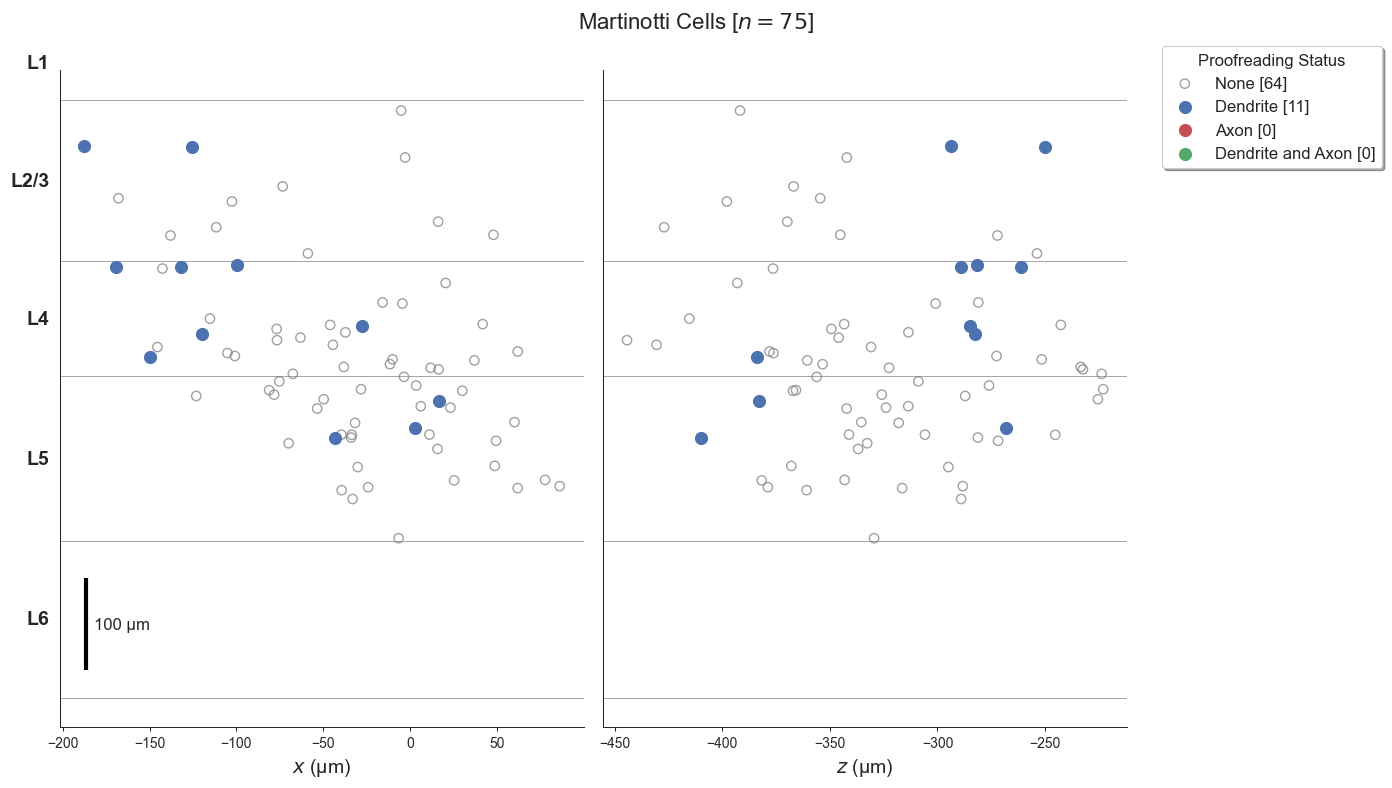

In [10]:
plot_cell_positions(mc_cells, "Martinotti Cells")

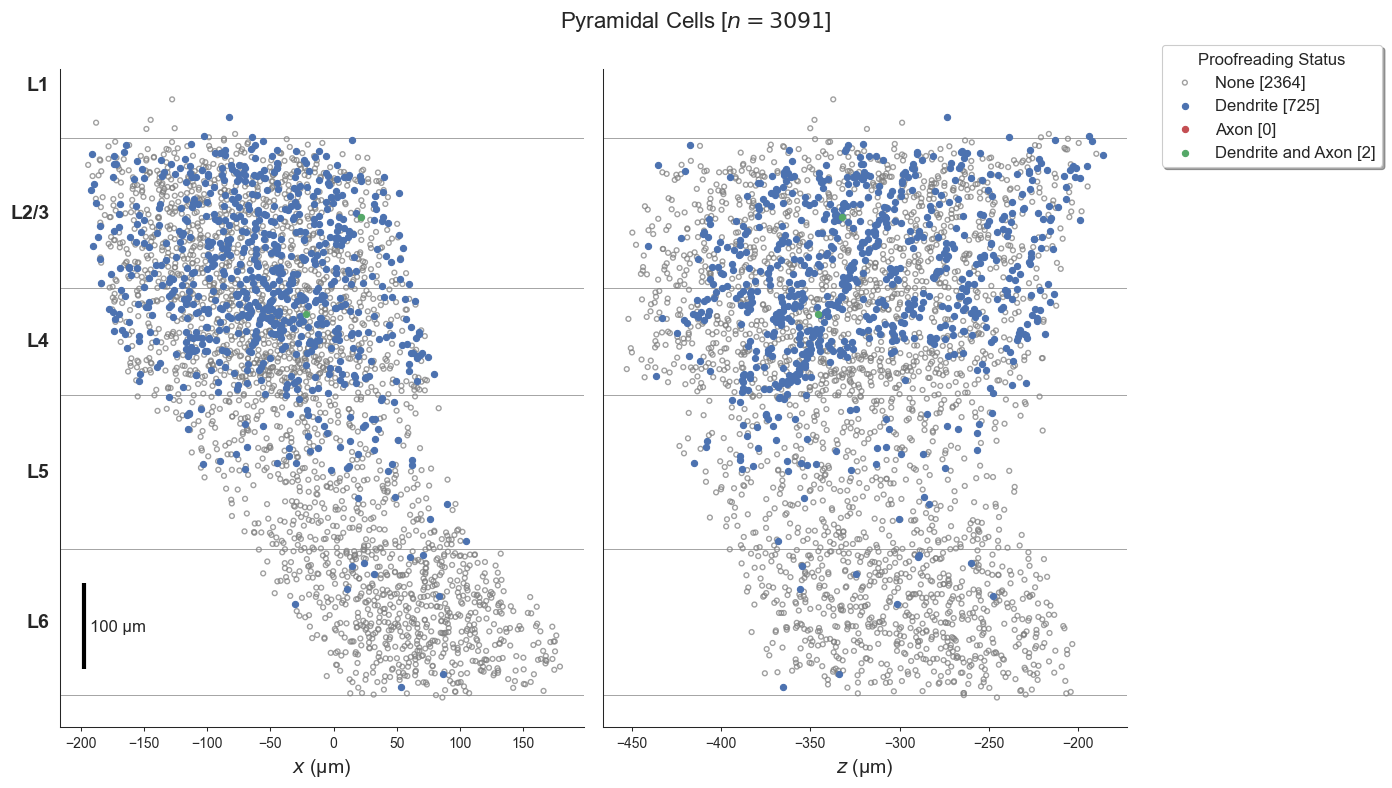

In [11]:
plot_cell_positions(cell_type_table[cell_type_table.cell_type == "PYC"], "Pyramidal Cells", s=20)

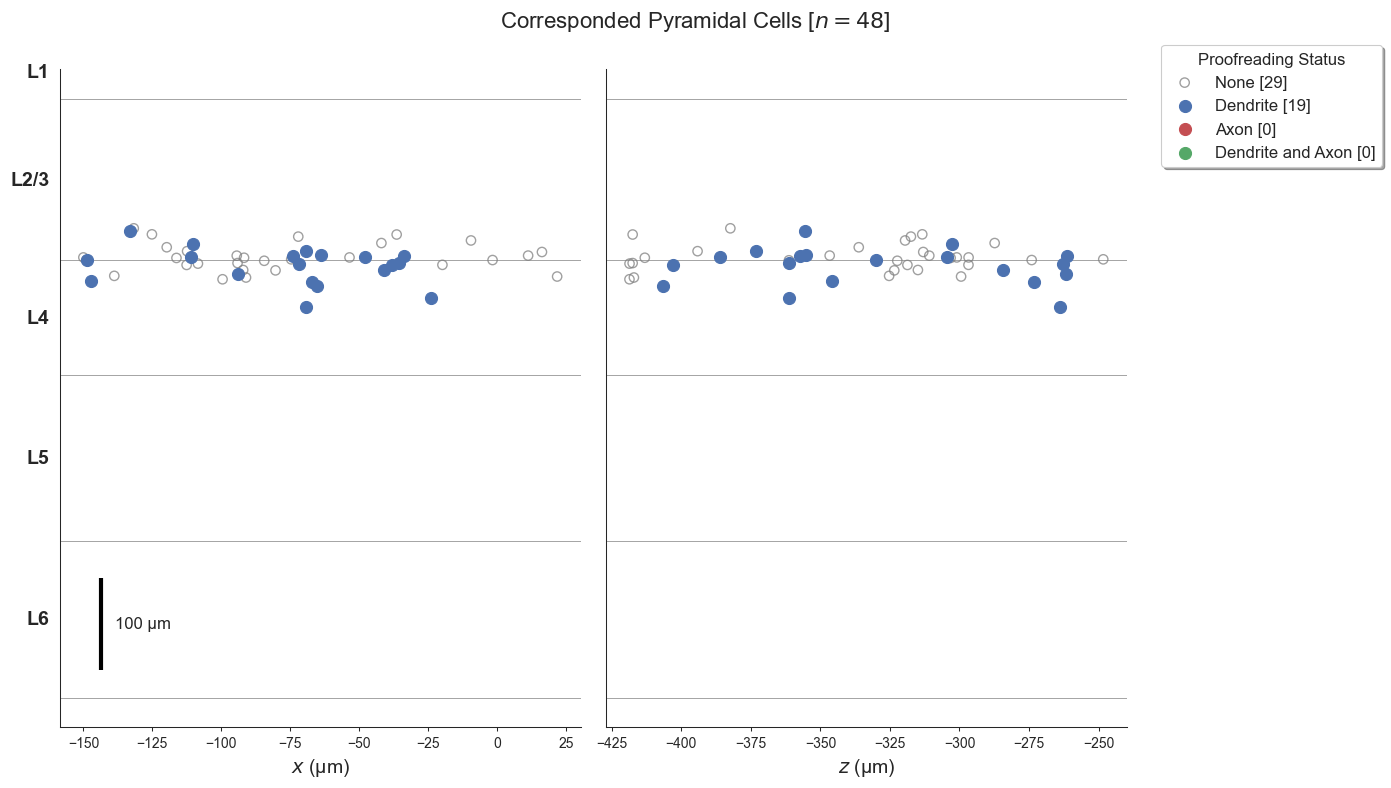

In [13]:
plot_cell_positions(em_client.get_2p_corresponded_table(), "Corresponded Pyramidal Cells")

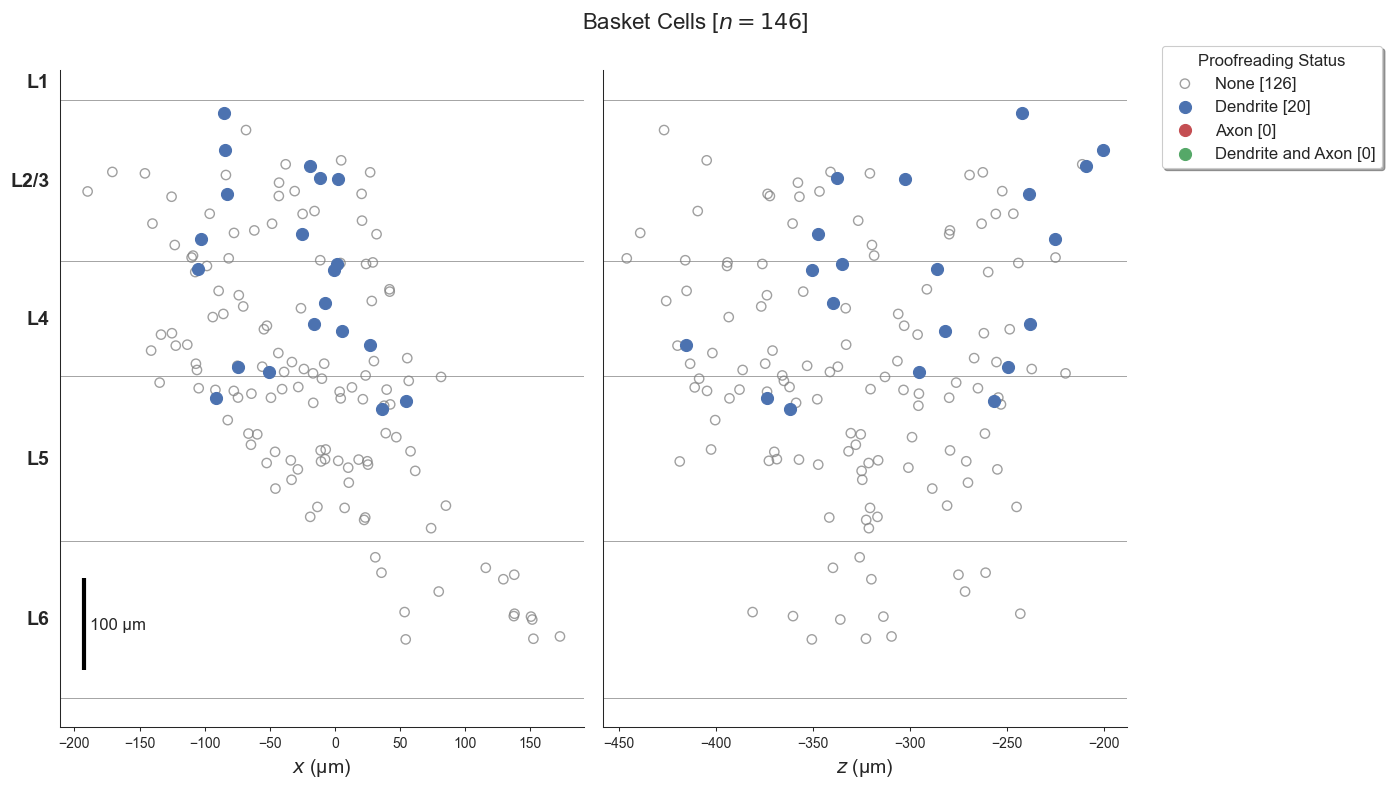

In [143]:
plot_cell_positions(cell_type_table[cell_type_table.cell_type == "BC"], "Basket Cells")

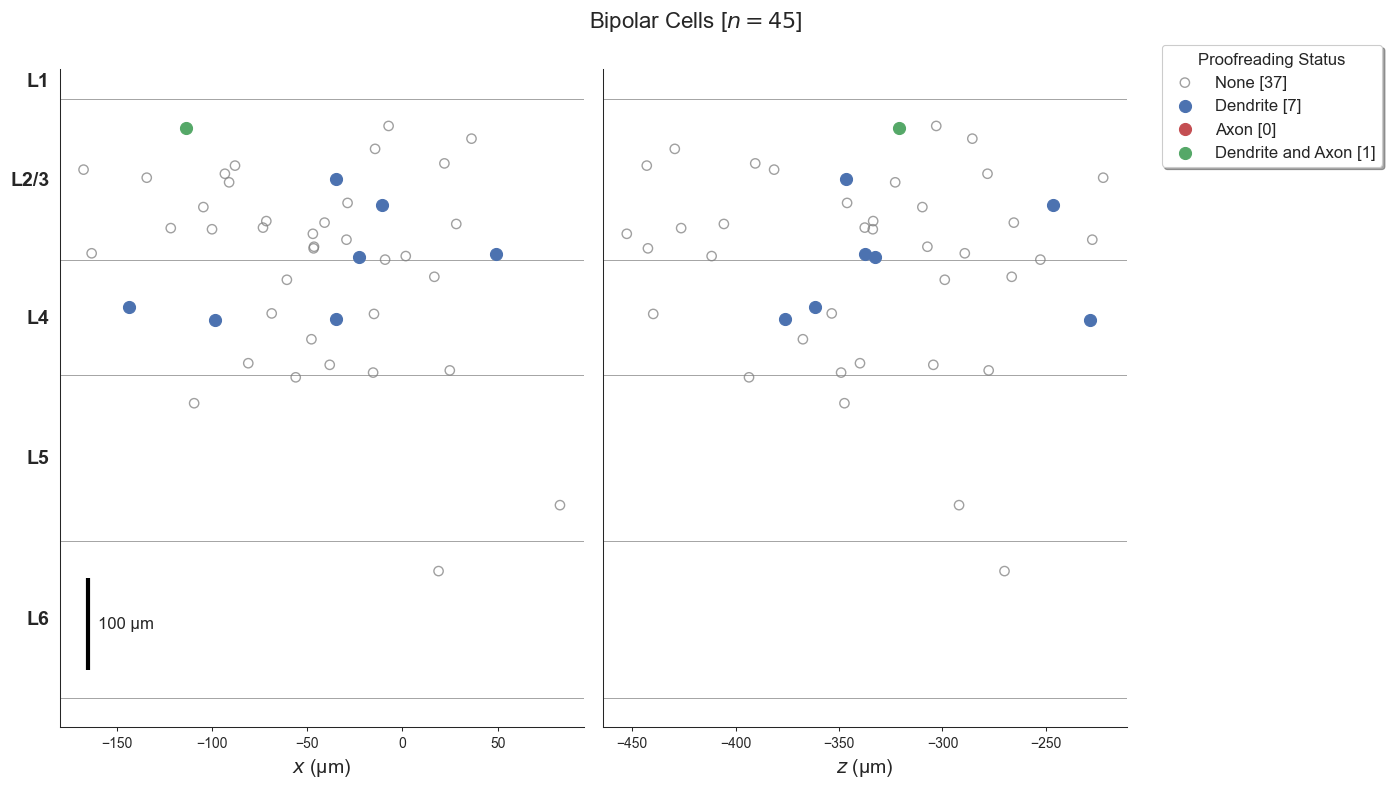

In [141]:
plot_cell_positions(cell_type_table[cell_type_table.cell_type == "BPC"], "Bipolar Cells")

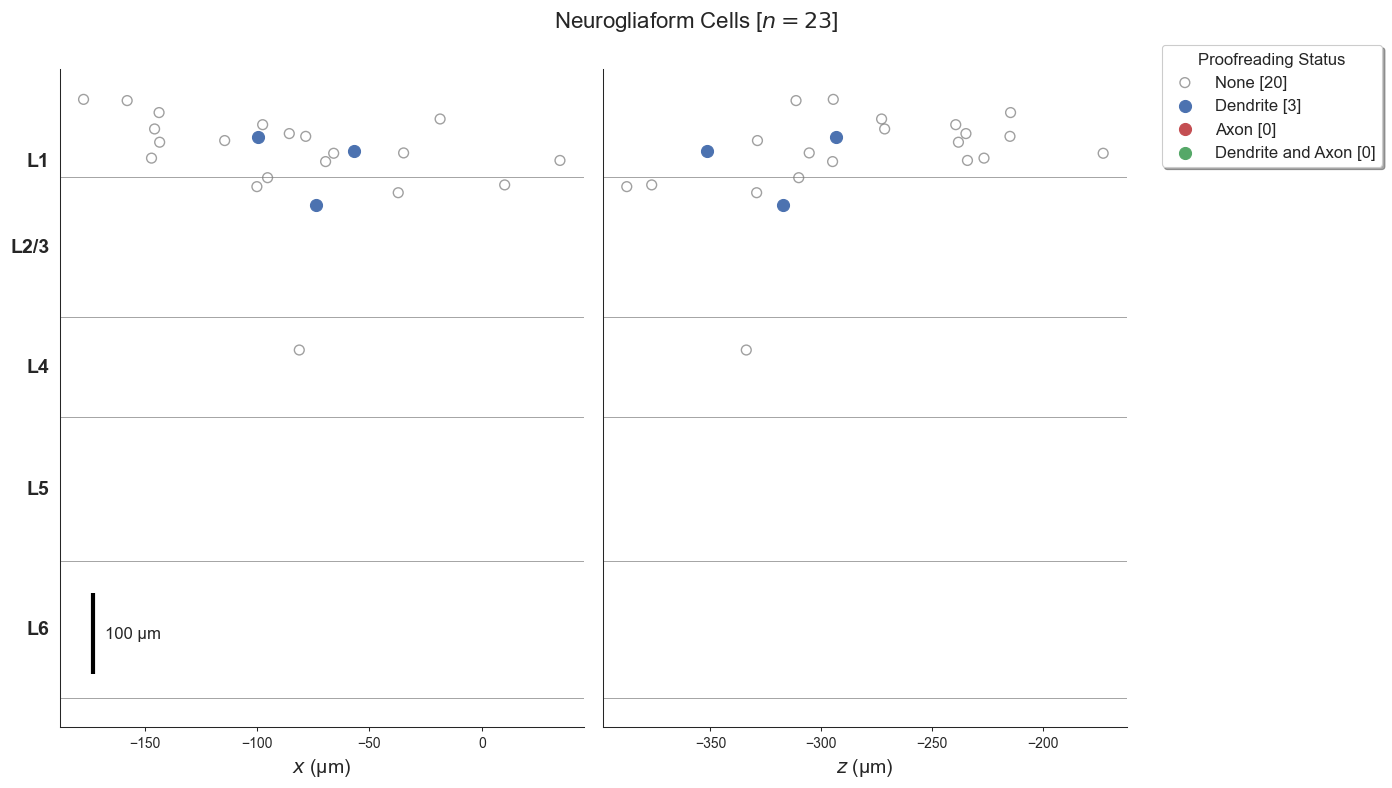

In [127]:
plot_cell_positions(cell_type_table[cell_type_table.cell_type == "NGC"], "Neurogliaform Cells")

# Load mesh data for all proofread Martinotti cells

In [33]:
table = em_client.get_cell_type_table()
table = table[(table.cell_type == "MC") & (table.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE))]
table.sort_values(by="position_microns", ascending=True, key=lambda series: series.apply(lambda x: x[1]), inplace=True) # sort by depth
print(f"There are {len(table)} proofread MCs")
proof_mc_root_ids = table.pt_root_id.values
proof_mc_root_ids

There are 11 proofread MCs


array([864691132718050986, 864691132967182957, 864691133121058917,
       864691132823412073, 864691132669322924, 864691132562619342,
       864691132764109698, 864691132623694274, 864691132803126118,
       864691132851057470, 864691133121080421])

In [34]:
# Load the neuron meshworks
mc_neuron_mws = []
for root_id in tqdm(proof_mc_root_ids, desc="Loading meshworks"):
    mc_neuron_mws.append(em_client.get_neuron_meshwork(root_id))

Loading meshworks:   0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/caveclient/l2cache.py:78: UserWarning: L2Cache is in an experimental stage
  warnings.warn("L2Cache is in an experimental stage", UserWarning)
100%|██████████| 10137/10137 [00:00<00:00, 19441.75it/s]


## Plot single Martinotti cell

In [276]:
def generate_rotation_gif(neuron_mw, save_file, rotation_deg_per_frame=2, seconds_per_rotation=6, figsize=(6, 8), legend_loc="lower right", **kwargs):
    soma_microns = em_client.transform_position_to_microns(neuron_mw.skeleton.root_position)
    soma_microns[1] = 0 # Keep y-coordinate true
    soma_mesh_microns = em_client.transform_position_to_microns(neuron_mw.mesh.vertices[neuron_mw.root_region]) - soma_microns
    vertices_microns = em_client.transform_position_to_microns(neuron_mw.mesh.vertices) - soma_microns
    den_syn_microns = em_client.transform_position_to_microns(neuron_mw.anno.post_syn.points) - soma_microns
    axo_syn_microns = em_client.transform_position_to_microns(neuron_mw.anno.pre_syn.points) - soma_microns

    rotation = R.from_euler("y", rotation_deg_per_frame, degrees=True)
    current_rotation_deg = 0

    with tempfile.TemporaryDirectory() as temp_dir:
        gif_files = []
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(f"{neuron_mw.seg_id}", fontsize=14)
        xlim = None
        ylim = None
        scatters = []

        for frame in tqdm(range(360 // rotation_deg_per_frame), desc="Generating GIF frames"):
            # Clear plot
            for scat in scatters: scat.remove()
            scatters.clear()

            # Plot            
            scatters.append(ax.scatter(vertices_microns[:, 0], vertices_microns[:, 1], s=1, color="black", alpha=0.25, label="Skeleton"))
            scatters.append(ax.scatter(soma_mesh_microns[:, 0], soma_mesh_microns[:, 1], s=10, alpha=1, color="black", label="Soma"))
            scatters.append(ax.scatter(den_syn_microns[:, 0], den_syn_microns[:, 1], s=0.5, color="turquoise", alpha=0.5, label="Dendritic Synapse"))
            scatters.append(ax.scatter(axo_syn_microns[:, 0], axo_syn_microns[:, 1], s=0.5, color="tomato", alpha=0.5, label="Axonal Synapse"))
            # ax.set_title(f"{neuron_mw.seg_id} rotated {current_rotation_deg}°", fontsize=14)

            if frame == 0:
                ax.invert_yaxis()
                max_x = np.max(np.abs(vertices_microns[:, 0])) * 1.2
                ax.axis("equal")
                ax.set_xlim(-max_x, max_x)
                label_layers(ax, label_text_position="left", remove_yticks=True, scale_bar=True, **kwargs)
                ax.xaxis.set_visible(False)
                xlim = ax.get_xlim()
                ylim = ax.get_ylim()

                # Create legend and make all points the same size
                legend = ax.legend(loc=legend_loc, markerscale=4)
                for handle in legend.legendHandles:
                    handle._sizes = [50]

                fig.tight_layout()
            # else:
            #     ax.set_xlim(xlim)
            #     ax.set_ylim(ylim)


            # Save file
            filename = path.join(temp_dir, f"{frame+1}.png")
            gif_files.append(filename)
            fig.savefig(filename)

            # Rotate the image for the next frame
            current_rotation_deg += rotation_deg_per_frame
            vertices_microns = rotation.apply(vertices_microns)
            soma_mesh_microns = rotation.apply(soma_mesh_microns)
            den_syn_microns = rotation.apply(den_syn_microns)
            axo_syn_microns = rotation.apply(axo_syn_microns)
        
        plt.close(fig)
        
        # frames/sec = frames/rotation * rotations/sec
        #            = frames/degree * 360 degrees/1 rotation * rotations/sec
        #            = 1/(rotations/frame) * 360 * 1/(seconds/rotation)
        #            = 360 / (rotations/frame * seconds/rotation)
        fps = max(1, int(360 / (rotation_deg_per_frame * seconds_per_rotation)))
        print(f"Saving GIF to {save_file} at {fps} FPS")
        with imageio.get_writer(save_file, mode="I", format="GIF", fps=fps) as writer:
            for file in gif_files:
                image = imageio.imread(file)
                writer.append_data(image)

    print("Done!")

In [250]:
neuron_mw = mc_neuron_mws[-1]
generate_rotation_gif(neuron_mw, save_file="/Users/chase/Desktop/example_mc_rotation.gif")

Generating GIF frames:   0%|          | 0/180 [00:00<?, ?it/s]

Saving GIF to /Users/chase/Desktop/example_mc_rotation.gif at 30 FPS


/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_36767/1274121756.py:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


Done!


In [280]:
table = em_client.get_2p_corresponded_table()
table = table[table.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)]
neuron_mw = em_client.get_neuron_meshwork(table.pt_root_id.iloc[0])
generate_rotation_gif(neuron_mw, save_file="/Users/chase/Desktop/example_pyc_rotation.gif", figsize=(8, 6), legend_loc="upper right", scale_bar_x_offset=50)

Generating GIF frames:   0%|          | 0/180 [00:00<?, ?it/s]

Saving GIF to /Users/chase/Desktop/example_pyc_rotation.gif at 30 FPS


/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_36767/1803338189.py:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


Done!


## Plot all Martinotti cells

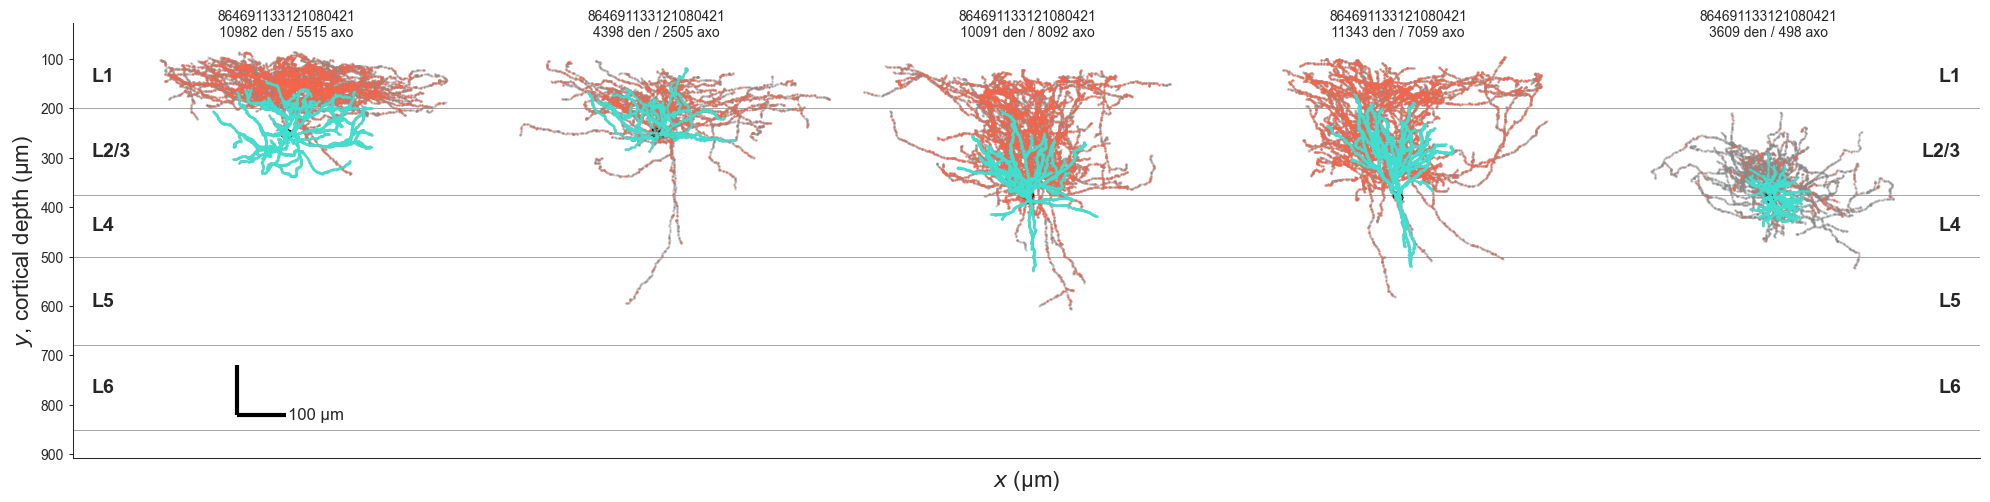

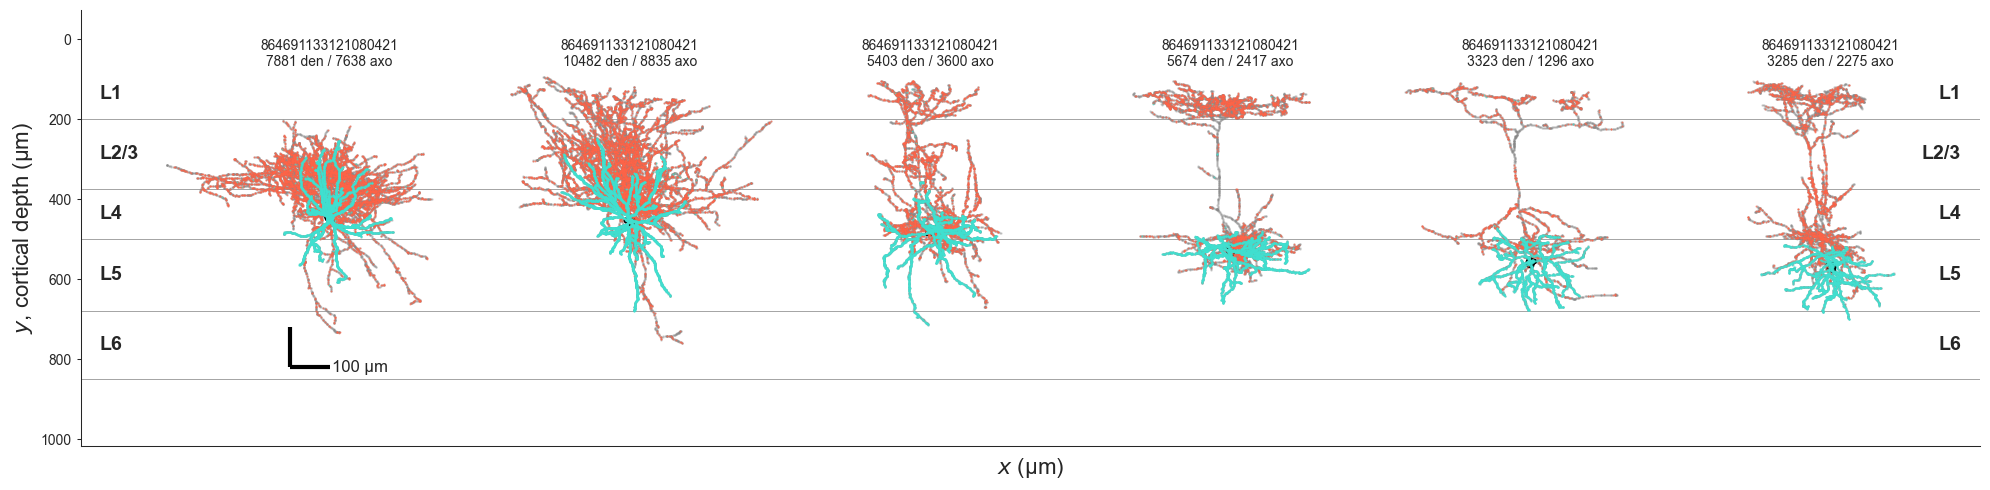

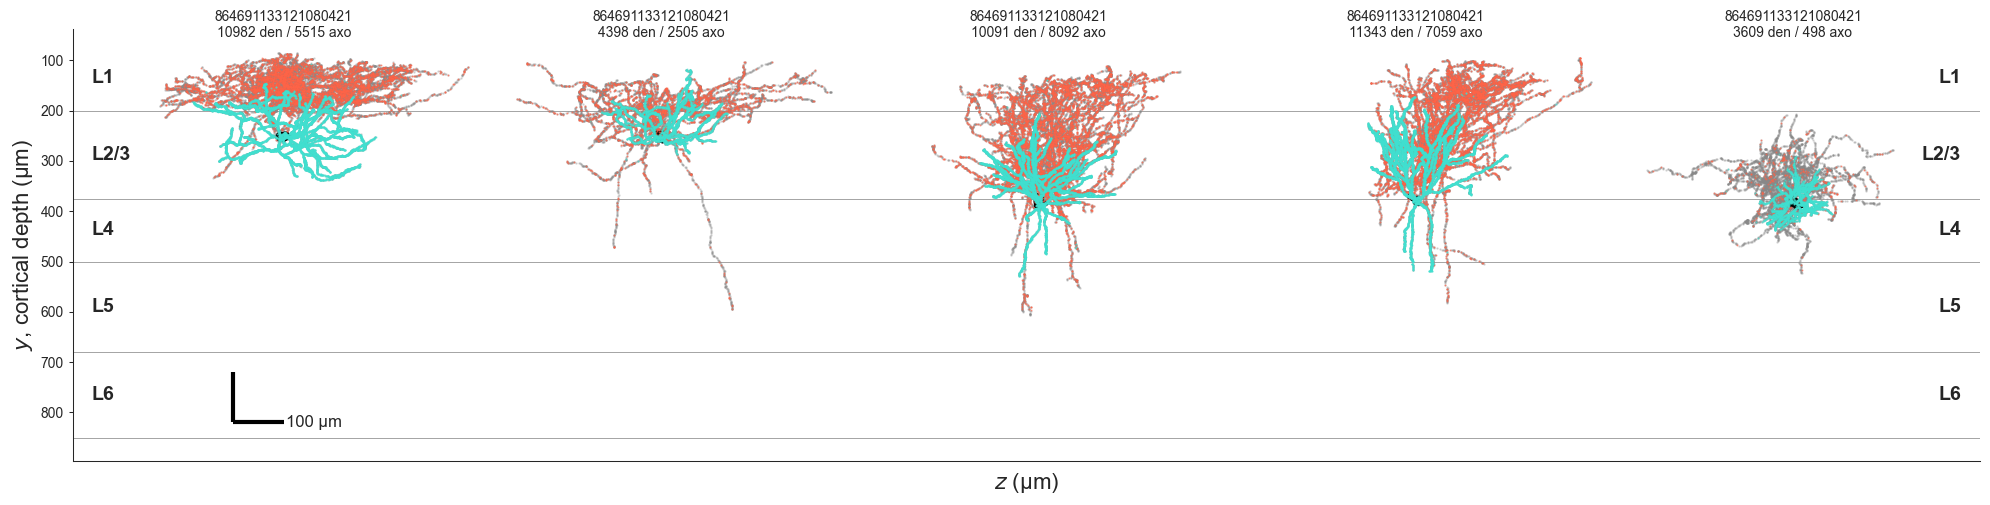

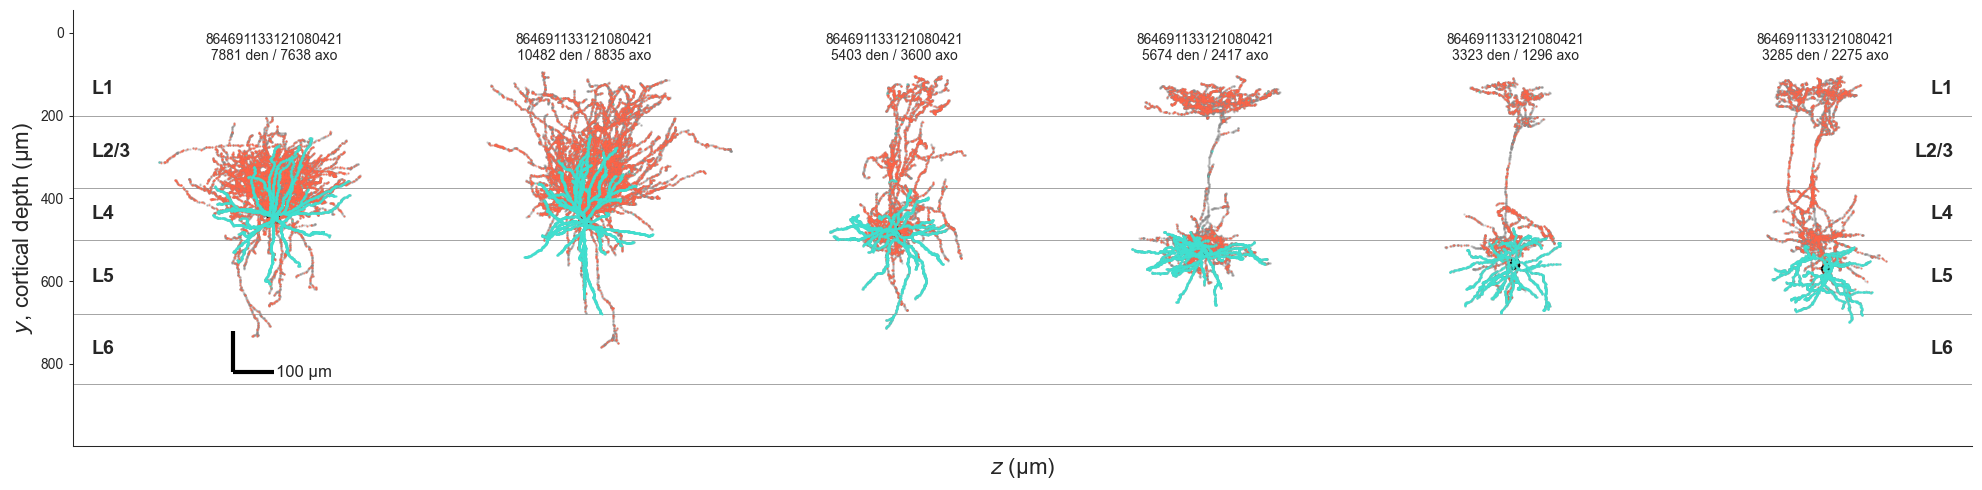

In [155]:
# Plot the mesh with microns transformation
for x_dim, x_label in ((0, "x"), (2, "z")):
    for mc_neurons_mws_split in (mc_neuron_mws[:5], mc_neuron_mws[5:]):
        fig, ax = plt.subplots(figsize=(20, 5))

        ax.text(105, 820, "100 µm", ha="left", va="center", fontsize=12)
        ax.hlines(y=820, xmin=0, xmax=100, color="black", linewidth=3)
        ax.vlines(x=0, ymin=720, ymax=820, color="black", linewidth=3)

        root_origin_x = 100
        for mw in mc_neurons_mws_split:
            em_client.plot_neuron_2d(
                mw,
                neuron_plot_dims=(x_dim, 1),
                plot_type="mesh", ax=ax, color="#888", root_origin=(root_origin_x, None),
                highlight_synapses="all",
            )
            n_den_syn = len(mw.anno.post_syn)
            n_axo_syn = len(mw.anno.pre_syn)
            label_text = f"{root_id}\n{n_den_syn} den / {n_axo_syn} axo"
            ax.text(x=root_origin_x, y=0, s=label_text, ha="center", va="top")
            root_origin_x += 750

        # Plot layer boundaries
        label_layers(ax, label_text_position="both", remove_yticks=False)

        ax.invert_yaxis() # Open down
        ax.set_xticks([])
        ax.set_xlabel(f"${x_label}$ (µm)", fontsize=16)
        ax.set_ylabel("$y$, cortical depth (µm)", fontsize=16)
        ax.axis("equal")
        # ax.set_title(f"Dendritic synapses for {root_id}")
        fig.tight_layout()

# TODO: Mimic the same plots on the right


In [38]:
corresponded = em_client.get_2p_corresponded_table()
corresponded.head()

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi_lookup,position_microns,axon_proofreading_status,dendrite_proofreading_status
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",1-3-3-14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,not_started
1,1,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]",1-3-1-60,"[-72.07225703497906, 349.1430176136275, -317.4...",not_started,not_started
2,2,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]",1-3-2-30,"[-119.78729184255074, 360.70596673244506, -336...",not_started,not_started
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",1-3-5-119,"[-147.1008040492488, 397.2344828991529, -345.9...",not_started,ariadne_qa
4,4,96,t,session13,plane1_0271,92547337557612090,864691132771662867,"[90300, 66348, 6009]",1-3-2-271,"[-94.38847650736024, 369.8469629730637, -310.8...",not_started,not_started


In [41]:
print("Loading MC dendritic synapses...")
mc_den_syn = em_client.get_dendritic_synapses(proof_mc_root_ids)
print("Loading MC axonal synapses...")
mc_axo_syn = em_client.get_axonal_synapses(proof_mc_root_ids)
print("Done!")

Loading MC dendritic synapses...
Loading MC axonal synapses...
Done!


In [ ]:
# Scatter plot: x = distance from presyn soma to MC soma; y = distance from dendritic synapse to MC soma

syn = mc_den_syn.dropna(subset="pre_soma_position")
presoma_postsoma_dist = syn.apply(lambda row: np.linalg.norm(row["pre_soma_position"] - row["post_soma_position"]), axis=1)
presoma_synapse_dist = syn.apply(lambda row: np.linalg.norm(row["pre_soma_position"] - row["position_microns"]), axis=1)
def neurite_dist(row):
    neuron_mw = em_client.get_neuron_meshwork(row["post_pt_root_id"])
    mesh_index = neuron_mw.anno.post_syn.df["post_pt_mesh_ind"][neuron_mw.anno.post_syn.df.id == row["id"]].values[0]
    dist = em_client.get_neurite_distance_to_root(neuron_mw, mesh_index=mesh_index)
    return dist
syn_postsoma_neurite_dist = syn.apply(neurite_dist, axis=1)


<AxesSubplot: xlabel='Pre soma to synapse distance (µm)', ylabel='Synapse to post soma distance (along dendrites; µm)'>

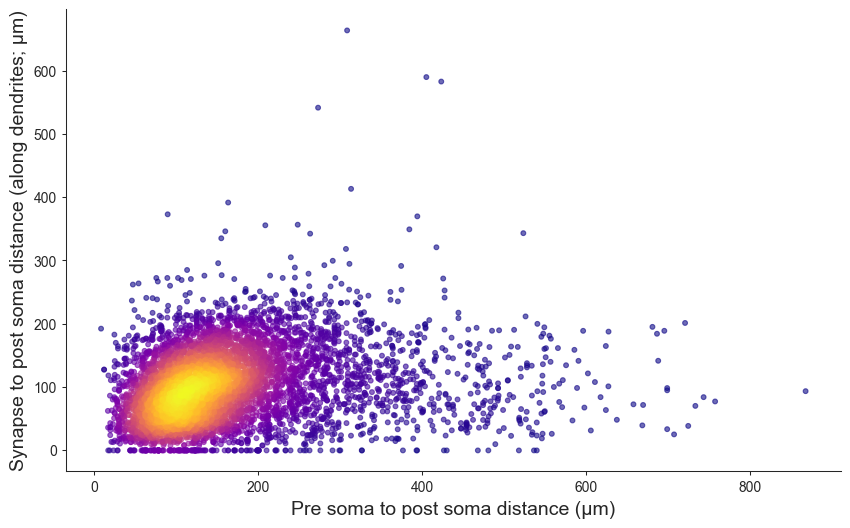

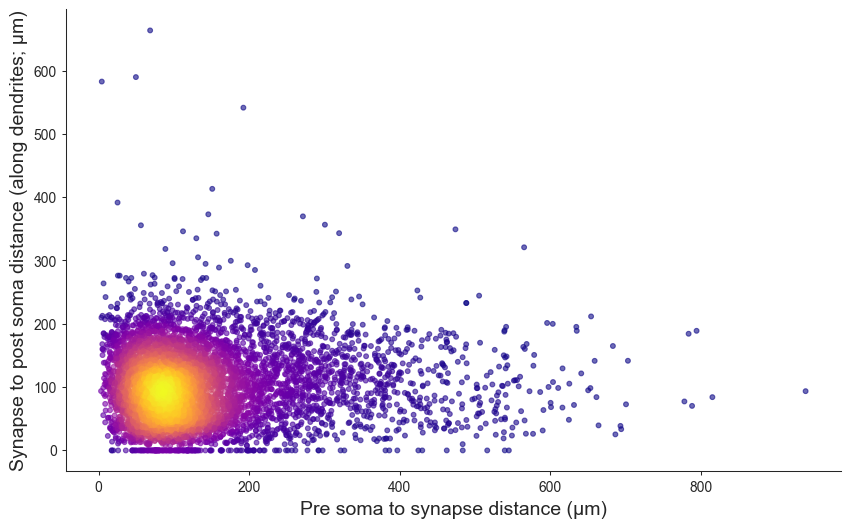

In [70]:
at.density_scatter(x=presoma_postsoma_dist, y=syn_postsoma_neurite_dist, figsize=(10, 6), xlabel="Pre soma to post soma distance (µm)", ylabel="Synapse to post soma distance (along dendrites; µm)")
at.density_scatter(x=presoma_synapse_dist, y=syn_postsoma_neurite_dist, figsize=(10, 6), xlabel="Pre soma to synapse distance (µm)", ylabel="Synapse to post soma distance (along dendrites; µm)")

In [78]:
mc_cells_proof

,index,id,valid,target_id,classification_system,cell_type,id_ref,valid__ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,axon_proofreading_status,dendrite_proofreading_status
27,27,2694,t,278405,coarse_manual,MC,278405,t,336.579200,90436412738338039,864691132823412073,"[737898, 601710, 294075]","[732777, 597520, 31127]","[742554, 605668, 32199]","[-169.1360545116018, 380.96626861854804, -289....",not_started,allen_qa
502,502,1828,t,295384,coarse_manual,MC,295384,t,355.882132,94449149210497298,864691132562619342,"[878898, 663635, 315810]","[874009, 658203, 33552]","[883942, 669688, 34532]","[-27.8118484251427, 445.74689403586916, -284.9...",not_started,allen_qa
796,796,2497,t,368033,coarse_manual,MC,368033,t,297.839471,95648303878105687,864691132803126118,"[922974, 768395, 243135]","[918784, 764438, 25700]","[928096, 772896, 26641]","[16.669197604257263, 527.0091305925961, -382.9...",not_started,ariadne_qa
962,962,2200,t,202750,coarse_manual,MC,202750,t,363.267399,89940395487724206,864691132718050986,"[719662, 476542, 254610]","[714774, 472118, 26820]","[725870, 481353, 28072]","[-188.02471897711231, 249.8942847266685, -293....",in_progress,allen_qa
1825,1827,3065,t,307365,coarse_manual,MC,307365,t,266.120001,93960759621012152,864691133121080421,"[862757, 813869, 228015]","[859187, 808126, 24148]","[867025, 819534, 24939]","[-43.34911009892251, 567.0753943605986, -409.7...",not_started,allen_qa
2055,2058,1095,t,266281,coarse_manual,MC,266281,t,246.494332,91699339281849838,864691132967182957,"[781975, 465755, 297270]","[778018, 460711, 31651]","[787019, 470954, 32432]","[-125.70738274211844, 250.61032781871327, -249...",in_progress,allen_qa
2143,2146,1856,t,295509,coarse_manual,MC,295509,t,397.117308,91845711834479185,864691132764109698,"[786864, 670386, 320220]","[781975, 666196, 33829]","[791598, 674422, 35051]","[-119.80645436573076, 453.89004221891355, -282...",not_started,allen_qa
2275,2278,1575,t,278505,coarse_manual,MC,278505,t,336.009601,92406668922503465,864691133121058917,"[807661, 597830, 300915]","[802927, 593097, 31937]","[812472, 602719, 32956]","[-99.38341323076317, 378.7116193209634, -281.6...",not_started,allen_qa
2445,2448,2491,t,370743,coarse_manual,MC,370743,t,282.585781,95296391773388115,864691132851057470,"[909084, 765912, 361485]","[904040, 761799, 38480]","[914128, 770180, 39348]","[2.9251574506089093, 556.3663805339849, -268.2...",not_started,ariadne_qa
2947,2951,2672,t,278915,coarse_manual,MC,278915,t,350.678789,91491806529245308,864691132669322924,"[775146, 595192, 321390]","[770646, 590381, 34066]","[779647, 599538, 35230]","[-131.8833802025528, 381.8126120605377, -261.2...",not_started,allen_qa


In [126]:
em_client.get_axon_proofreading_table()

HTTPError: 410 Client Error: GONE for url: https://api.em.brain.allentech.org/materialize/api/v2/datastack/v1dd/version/264/table/ariadne_axon_proofreading_v1/query?return_pyarrow=True&split_positions=True content: b'{"message": "This materialization version is not available"}\n'

In [125]:
corresponded

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi_lookup,position_microns,axon_proofreading_status,dendrite_proofreading_status
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",1-3-3-14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,not_started
1,1,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]",1-3-1-60,"[-72.07225703497906, 349.1430176136275, -317.4...",not_started,not_started
2,2,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]",1-3-2-30,"[-119.78729184255074, 360.70596673244506, -336...",not_started,not_started
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",1-3-5-119,"[-147.1008040492488, 397.2344828991529, -345.9...",not_started,ariadne_qa
4,4,96,t,session13,plane1_0271,92547337557612090,864691132771662867,"[90300, 66348, 6009]",1-3-2-271,"[-94.38847650736024, 369.8469629730637, -310.8...",not_started,not_started
5,5,37,t,session13,plane2_roi_0269,93109944114777440,864691132807412738,"[92493, 64925, 7372]",1-3-3-269,"[-74.63141709996748, 373.8276859071403, -248.3...",not_started,not_started
6,6,94,t,session13,plane1_0262,95573468367740795,864691132573738810,"[102044, 67460, 5245]",1-3-2-262,"[11.308402525398183, 369.7604962433013, -346.6...",not_started,not_started
7,7,39,t,session13,plane2_roi_0158,95150912506684625,864691132594653239,"[100608, 65812, 6828]",1-3-3-158,"[-1.5916540129779606, 374.602796307896, -274.0...",not_started,not_started
8,8,40,t,session13,plane2_roi_0230,94658606108307469,864691133065754585,"[98584, 67037, 6372]",1-3-3-230,"[-19.781894514350686, 379.8231010230511, -296....",not_started,not_started
9,9,87,t,session13,plane0_0088,94166024496769248,864691132630689634,"[96758, 67089, 3591]",1-3-1-88,"[-36.38019665927964, 346.8564369779331, -417.4...",not_started,not_started


In [89]:
em_client.transform_position_to_microns(np.vstack(neuron_mw.anno.post_syn.df.post_pt_position), df=neuron_mw.anno.post_syn.df)

array([[  60.98728567,  616.21568984, -196.61930529],
       [ -43.40679917,  539.93641112, -298.02204421],
       [ -77.8047971 ,  592.27601201, -268.89369327],
       ...,
       [  66.58546661,  651.53588861, -190.09327273],
       [-106.18586349,  602.31794173, -268.84206182],
       [  96.80793717,  602.19456096, -339.75233678]])

In [115]:
neuron_mw.distance_to_root

(array([740307.52731323]), 740307.5273132324)

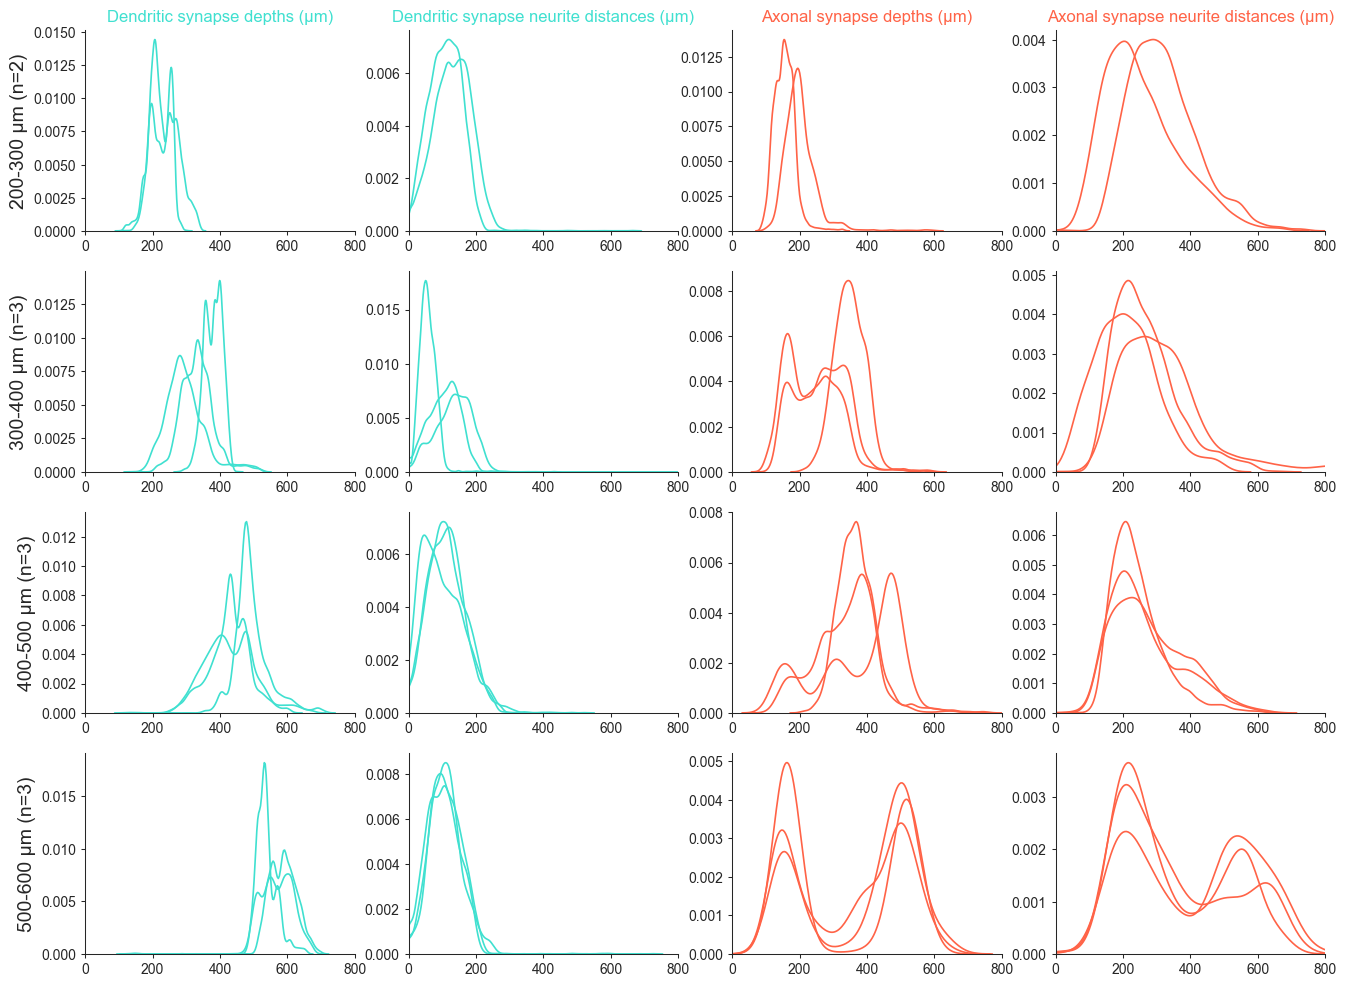

In [123]:
nrows, ncols = len(V1DDEMClient.LAYER_NAMES)-1, 4
fig, axs = plt.subplots(figsize=(ncols*4, nrows*3), nrows=nrows, ncols=ncols)

def plot():
    pass

for row in range(nrows):
    # depth_min, depth_max = V1DDEMClient.LAYER_BOUNDARIES[row:row+2]
    # layer_name = V1DDEMClient.LAYER_NAMES[row+1]
    depth_min = 200 + row*100
    depth_max = depth_min + 100
    root_ids = mc_cells_proof.pt_root_id[mc_cells_proof.position_microns.apply(lambda pos: depth_min <= pos[1] < depth_max)]

    # axs[row, 0].set_ylabel(f"L{layer_name} ({depth_min}-{depth_max} µm)", fontsize=14)
    axs[row, 0].set_ylabel(f"{depth_min}-{depth_max} µm (n={len(root_ids)})", fontsize=14)

    for root_id in root_ids:
        neuron_mw = em_client.get_neuron_meshwork(root_id)

        # Column 1: Dendritic synapses at depth
        ax = axs[row, 0]
        den_syn_pos = em_client.transform_position_to_microns(np.vstack(neuron_mw.anno.post_syn.df.post_pt_position), df=neuron_mw.anno.post_syn.df)
        sns.kdeplot(x=den_syn_pos[:, 1], color="turquoise", ax=ax)
        ax.set_xlim(0, 800)
        if row == 0: ax.set_title("Dendritic synapse depths (µm)", color="turquoise")

        # Column 2: Dendritic synapse neurite distances
        ax = axs[row, 1]
        den_syn_neurite_dists = em_client.get_neurite_distance_to_root(neuron_mw, mesh_index=neuron_mw.anno.post_syn.mesh_index)
        sns.kdeplot(x=den_syn_neurite_dists, color="turquoise", ax=ax)
        if row == 0: ax.set_title("Dendritic synapse neurite distances (µm)", color="turquoise")
        ax.set_xlim(0, 800)
        ax.set_ylabel("")

        # Column 3: Axonal synapses at depth
        ax = axs[row, 2]
        axo_syn_pos = em_client.transform_position_to_microns(np.vstack(neuron_mw.anno.pre_syn.df.post_pt_position), df=neuron_mw.anno.pre_syn.df)
        sns.kdeplot(x=axo_syn_pos[:, 1], color="tomato", ax=ax)
        ax.set_xlim(0, 800)
        if row == 0: ax.set_title("Axonal synapse depths (µm)", color="tomato")
        ax.set_ylabel("")

        # Column 4: Axonal synapse neurite distances
        ax = axs[row, 3]
        axo_syn_neurite_dists = em_client.get_neurite_distance_to_root(neuron_mw, mesh_index=neuron_mw.anno.pre_syn.mesh_index)
        sns.kdeplot(x=axo_syn_neurite_dists, color="tomato", ax=ax)
        if row == 0: ax.set_title("Axonal synapse neurite distances (µm)", color="tomato")
        ax.set_xlim(0, 800)
        ax.set_ylabel("")

# Corresponded analysis

In [25]:
corresponded_den_proof = corresponded[corresponded.dendrite_proofreading_status.isin(V1DDEMClient.PROOFREADING_STATUS_COMPLETE)]
print(len(corresponded_den_proof))
corresponded_den_proof

19


,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi_lookup,position_microns,axon_proofreading_status,dendrite_proofreading_status
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",1-3-5-119,"[-147.1008040492488, 397.2344828991529, -345.9...",not_started,ariadne_qa
10,10,88,t,session13,plane1_0075,93392105950991300,864691132630689122,"[93706, 67632, 5059]",1-3-2-75,"[-63.736396272770016, 369.3849977790961, -355....",not_started,allen_qa
14,14,48,t,session13,plane2_roi_0025,94235843954739595,864691132835126165,"[97048, 64977, 7072]",1-3-3-25,"[-33.65266860667232, 370.4608009240667, -261.4...",not_started,allen_qa
15,15,49,t,session13,plane2_roi_0074,92055374622340898,864691132598347327,"[88461, 68719, 4404]",1-3-3-74,"[-110.93316641399136, 371.15582529042194, -386...",not_started,allen_qa
16,16,50,t,session13,plane0_roi_0065,91421093919056079,864691132621003707,"[86003, 64732, 4886]",1-3-1-65,"[-133.19808602945076, 342.4989722512487, -355....",in_progress,allen_qa
17,17,103,t,session13,plane3_0089,93393411553455652,864691132827688129,"[93499, 72719, 4155]",1-3-4-89,"[-65.43400252395776, 402.61649847251164, -406....",not_started,allen_qa
18,18,101,t,session13,plane2_0191,93110699693734118,864691132678493470,"[92585, 67831, 5022]",1-3-3-191,"[-73.81890019900177, 370.71513983959437, -357....",not_started,allen_qa
20,20,105,t,session13,plane4_0109,93321943633527277,864691132656860120,"[93318, 68348, 6990]",1-3-5-109,"[-67.08166382155882, 398.8715816165777, -273.1...",not_started,allen_qa
24,24,60,t,session13,plane1_roi_0026,93251368462113682,864691132924264745,"[93107, 67702, 4644]",1-3-2-26,"[-69.14919163411437, 365.0198245600475, -373.2...",not_started,allen_qa
25,25,104,t,session13,plane3_0306,92547543850425640,864691132721900430,"[90343, 67037, 7181]",1-3-4-306,"[-93.90146758848941, 389.9373440435976, -261.6...",not_started,allen_qa


In [18]:
# Load dendritic synapses (i.e., presynaptic cells) for these 2P-corresponded dendritic proofreading PYCs
den_syn = em_client.get_dendritic_synapses(postsyn_pt_root_id=corresponded_den_proof.pt_root_id)

In [21]:
# Get soma positions for presyn cells
soma_pos = em_client.get_soma_positions(pt_root_ids=den_syn.pre_pt_root_id)

In [19]:
cell_type_table = em_client.get_cell_type_table()

In [124]:
for corresponded_root_id in corresponded_den_proof.pt_root_id:
    syn = den_syn[den_syn.post_pt_root_id == corresponded_root_id]
    unique_presyn = syn.pre_pt_root_id.unique()
    n_den_syn = len(syn)
    n_unique_presyn_has_soma = np.isin(unique_presyn, soma_pos.pt_root_id).sum()
    n_unique_presyn_has_type = np.isin(unique_presyn, cell_type_table.pt_root_id).sum()

    print(f"{corresponded_root_id}: {np.isin(syn.pre_pt_root_id, cell_type_table.pt_root_id).sum()} / {np.isin(syn.pre_pt_root_id, soma_pos.pt_root_id).sum()} / {n_den_syn} ({n_unique_presyn_has_type} / {n_unique_presyn_has_soma} / {len(unique_presyn)})")

864691132741334425: 175 / 353 / 2549 (67 / 174 / 2254)
864691132630689122: 172 / 272 / 2775 (87 / 166 / 2595)
864691132835126165: 149 / 286 / 2710 (82 / 186 / 2531)
864691132598347327: 153 / 272 / 3243 (92 / 189 / 3060)
864691132621003707: 180 / 339 / 3627 (91 / 219 / 3368)
864691132827688129: 124 / 202 / 1878 (63 / 130 / 1745)
864691132678493470: 153 / 244 / 2256 (80 / 156 / 2119)
864691132656860120: 194 / 333 / 2946 (87 / 194 / 2719)
864691132924264745: 257 / 384 / 3934 (104 / 205 / 3598)
864691132721900430: 56 / 131 / 928 (34 / 91 / 861)
864691132829082994: 187 / 409 / 3136 (82 / 228 / 2847)
864691132738257819: 173 / 318 / 3403 (88 / 208 / 3201)
864691132712062021: 276 / 421 / 3144 (105 / 201 / 2782)
864691132834513288: 216 / 332 / 3303 (114 / 198 / 3074)
864691132834400136: 118 / 218 / 1532 (64 / 131 / 1389)
864691132919547915: 157 / 264 / 2105 (75 / 157 / 1895)
864691132734110231: 236 / 387 / 3710 (120 / 234 / 3414)
864691132729544320: 104 / 171 / 1067 (57 / 113 / 975)
86469113268